In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn . model_selection import train_test_split
from sklearn . preprocessing import LabelEncoder , OneHotEncoder
from sklearn . metrics import confusion_matrix ,classification_report
import matplotlib . pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
# Fonctions d’activation
def relu (x ):
    """
    ReLU activation : max (0 , x)
    """
    assert isinstance (x , np . ndarray ) , " Input to ReLU must be a numpy array "
    result = np . maximum (0 , x)
    assert np . all ( result >= 0) , " ReLU output must be non - negative "
    return result

def relu_derivative ( x) :
    """
    Derivative of ReLU : 1 if x > 0 , else 0
    """
    assert isinstance (x , np . ndarray ) , " Input to ReLU derivative must be a numpy array "
    result = np . where (x > 0 , 1 , 0)
    assert np . all (( result == 0) | ( result == 1) ) , " ReLU derivativemust be 0 or 1"
    return result
    
def softmax ( x):
    """
    Softmax activation : exp (x) / sum ( exp (x))
    """
    assert isinstance (x , np . ndarray ) , " Input to softmax must be a numpy array "
    exp_x = np . exp ( x - np . max ( x , axis =1 , keepdims = True ))

    result = exp_x / np .sum ( exp_x , axis =1 , keepdims = True )
    assert np . all (( result >= 0) & ( result <= 1) ) , " Softmax output must be in [0 , 1]"
    
    assert np . allclose ( np .sum ( result , axis =1) , 1) , " Softmax output sum to 1 per sample "
    
    return result

In [3]:
# Classe MultiClassNeuralNetwork
class MultiClassNeuralNetwork:
    def __init__(self , layer_sizes , model_optimization,learning_rate =0.01):
        """
        Initialize the neural network with given layer sizes and
        learning rate.
        layer_sizes: List of integers [input_size , hidden1_size ,
        ..., output_size]
        """
        assert isinstance(layer_sizes , list) and len(layer_sizes)>= 2, "layer_sizes must be a list with at least 2elements"
        assert all(isinstance(size , int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate , (int , float)) and learning_rate > 0, "Learning rate must be a positivenumber"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        self.model_optimization=model_optimization


        # Initialisation des poids et biais
        np.random.seed (42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1])* 0.01
            b = np.zeros((1, layer_sizes[i+1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i+1]),f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector{i+1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)
            # Initialisation des variables pour l'optimiseur Adam APRÈS l'initialisation des poids et biais
        self.m_w = [np.zeros_like(w) for w in self.weights]
        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.v_b = [np.zeros_like(b) for b in self.biases]
        self.t = 0 # time step
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8 # une variable epsilon pour eviter la division sur 0

    def forward(self , X):
        """
        Forward propagation: Z^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]}, A^{[l]} = g(Z^{[l]})
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape [1] == self.layer_sizes [0], f"Input dimension ({X.shape [1]}) must match input layer size ({self.layer_sizes [0]})"
        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1],self.weights[i])+self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]),f"Z^{[i+1]} has incorrect shape"
            self.z_values.append(z)
            self.activations.append(relu(z))

        z=np.dot(self.activations[-1],self.weights[-1])+self.biases[-1]

        assert z.shape == (X.shape[0], self.layer_sizes [-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        
        output = softmax(z)
        assert output.shape == (X.shape[0], self.layer_sizes [-1]),"Output A has incorrect shape"
        self.activations.append(output)

        return self.activations [-1]

    def compute_loss(self , y_true , y_pred):
        """
        Categorical Cross -Entropy: J = -1/m * sum(y_true * log(y_pred))
        """
        assert isinstance(y_true , np.ndarray) and isinstance(y_pred , np.ndarray), "Inputs to loss must be numpy arrays"

        assert y_true.shape == y_pred.shape , "y_true and y_pred must have the same shape"

        y_pred = np.clip(y_pred , 1e-15, 1 - 1e-15)
        m = y_true . shape [0]

        loss = (-1/m)*np.sum(y_true*np.log(y_pred))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
                             
        return loss 

    def compute_accuracy(self , y_true , y_pred):
        """
        Compute accuracy: proportion of correct predictions
        """
        assert isinstance(y_true , np.ndarray) and isinstance(y_pred , np.ndarray), "Inputs to accuracy must be numpy arrays"

        assert y_true.shape == y_pred.shape , "y_true and y_pred must have the same shape"

        predictions = np.argmax(y_pred , axis =1)

        true_labels = np.argmax(y_true , axis =1)
        accuracy = np.mean(predictions == true_labels)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self , X, y, outputs):
        """
        Backpropagation: compute dW^{[l]}, db^{[l]} for each layer
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs , np.ndarray), "Inputs to backward must be numpy arrays"

        assert X.shape [1] == self.layer_sizes [0], f"Input dimension ({X.shape [1]}) must match input layer size ({self.layer_sizes [0]})"

        assert y.shape == outputs.shape , "y and outputs must have the same shape"

        m = X.shape [0]
        self.d_weights = [ np . zeros_like (w ) for w in self . weights ]
        self.d_biases = [ np . zeros_like ( b) for b in self . biases ]

        dZ = outputs - y # Gradient pour softmax + cross -entropy
        assert dZ.shape == outputs.shape , "dZ for output layer has incorrect shape"
        self.d_weights [-1] = (self.activations [-2].T @ dZ) / m
        self.d_biases [-1] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(len(self.weights) - 2, -1, -1):
            # dZ = np.dot(dZ[i+1],self.weights[i+1].T)*relu_derivative(self.z_values[i])#TODO
            dZ = dZ @ self.weights[i+1].T
            dZ = dZ * relu_derivative(self.z_values[i])
            assert dZ.shape == (X.shape[0], self.layer_sizes[i+1]), f"dZ^{[i+1]} has incorrect shape"
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

        # TODO: Ajouter une r gularisation L2 aux gradients des poids

        # dW^{[l]} += lambda * W^{[l]} / m, o lambda est le coefficient de r gularisation
        lamda=0.1
        for i in range(len(self.weights)):
            self.d_weights[i]+=lamda*self.weights[i]/m
        

        if self.model_optimization == "SGD":
            # calcule avec gradient descent stochastic
            for i in range (len ( self . weights )) :
              self. weights [ i] -= self . learning_rate * self . d_weights [ i]
              self . biases [ i] -= self . learning_rate * self . d_biases [ i]
        elif self.model_optimization == "Adam":
            # calcule avec Adam
            self.t += 1 # Increment time step per batch
    
            for i in range (len ( self . weights )) :
                # Mise à jour des moments
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * self.d_weights[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (self.d_weights[i]**2)
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * self.d_biases[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (self.d_biases[i]**2)
    
                # Correctif de biais
                m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)# mise à jour du 1er moment (momentum)
                v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)# mise à jour du 2e moment (RMS)
                m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)# mise à jour du 1er moment (momentum) (sur le biais)
                v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)# mise à jour du 2e moment (RMS)(sur le biais)
    
                # Update des paramètres
                self . weights [ i] -= self . learning_rate  * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self . biases [ i] -= self . learning_rate  * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)






    def train(self , X, y, X_val , y_val , epochs , batch_size):
        """
        Train the neural network using mini -batch SGD , with validation
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val , np.ndarray) and isinstance(y_val ,np.ndarray), "X_val and y_val must be numpy arrays"

        assert X.shape [1] == self.layer_sizes [0], f"Input dimension ({X.shape [1]}) must match input layer size ({self.layer_sizes [0]})"
        assert y.shape [1] == self.layer_sizes [-1], f"Output dimension ({y.shape [1]}) must match output layer size({self.layer_sizes [-1]})"
        assert X_val.shape [1] == self.layer_sizes [0], f"Validation input dimension ({X_val.shape [1]}) must match input layer size ({self.layer_sizes [0]})"
        assert y_val.shape [1] == self.layer_sizes [-1], f"Validation output dimension ({y_val.shape [1]}) must match output layer size ({self.layer_sizes [-1]})"
        assert isinstance(epochs , int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size , int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape [0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch , outputs)
                self.backward(X_batch , y_batch , outputs)

            # Calculer les pertes et accuracies
            train_loss = epoch_loss / (X.shape [0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val , val_pred)
            val_accuracy = self.compute_accuracy(y_val , val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss :.4f}, Val Loss: {val_loss :.4f}, "f"Train Acc: {train_accuracy :.4f}, Val Acc:{val_accuracy :.4f}")

        return train_losses , val_losses , train_accuracies ,val_accuracies

    def predict(self , X):
        """
        Predict class labels
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape [1] == self.layer_sizes [0], f"Input dimension ({X.shape [1]}) must match input layer size ({self.layer_sizes [0]})"

        outputs = self.forward(X)
        predictions = np.argmax(outputs , axis =1)
        assert predictions.shape == (X.shape[0],), "Predictions have incorrect shape"
        return predictions


/Users/hicham/Downloads/images-data-64/tifinagh-images
/Users/hicham
Loaded 28182 samples with 33 unique classes.
Train: 16908 samples , Validation: 5637 samples , Test: 5637 samples
Epoch 0, Train Loss: 3.5033, Val Loss: 3.4965, Train Acc: 0.0394, Val Acc:0.0364
Epoch 10, Train Loss: 3.5030, Val Loss: 3.4962, Train Acc: 0.0423, Val Acc:0.0406
Epoch 20, Train Loss: 3.3789, Val Loss: 3.3390, Train Acc: 0.0642, Val Acc:0.0653
Epoch 30, Train Loss: 2.8450, Val Loss: 2.8563, Train Acc: 0.1366, Val Acc:0.1332
Epoch 40, Train Loss: 2.2684, Val Loss: 2.2707, Train Acc: 0.3066, Val Acc:0.3012
Epoch 50, Train Loss: 1.6359, Val Loss: 1.6738, Train Acc: 0.5002, Val Acc:0.4836
Epoch 60, Train Loss: 1.2602, Val Loss: 1.3201, Train Acc: 0.6216, Val Acc:0.5918
Epoch 70, Train Loss: 0.9812, Val Loss: 1.0433, Train Acc: 0.7091, Val Acc:0.6789
Epoch 80, Train Loss: 0.7781, Val Loss: 0.8851, Train Acc: 0.7632, Val Acc:0.7234
Epoch 90, Train Loss: 0.6435, Val Loss: 0.7369, Train Acc: 0.8197, Val Acc:0.776

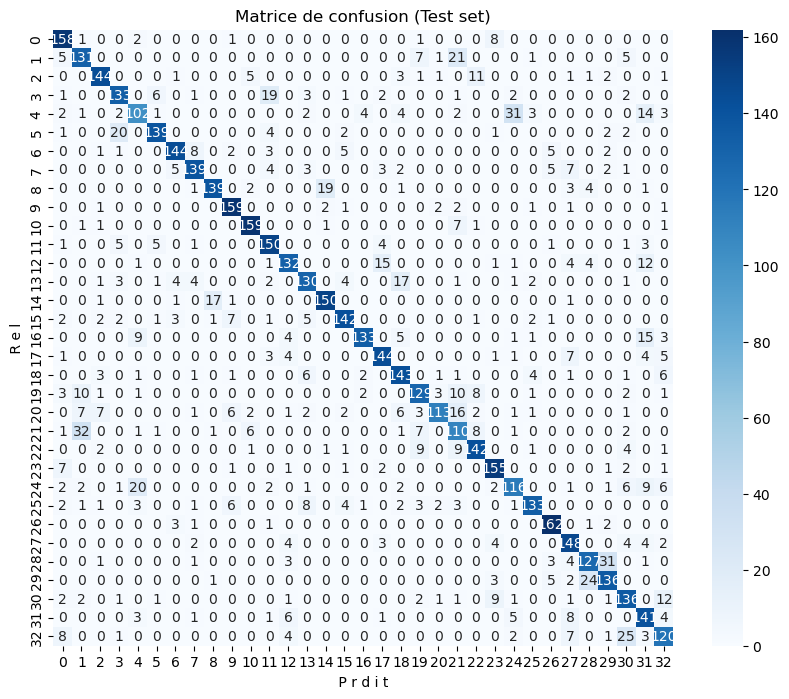

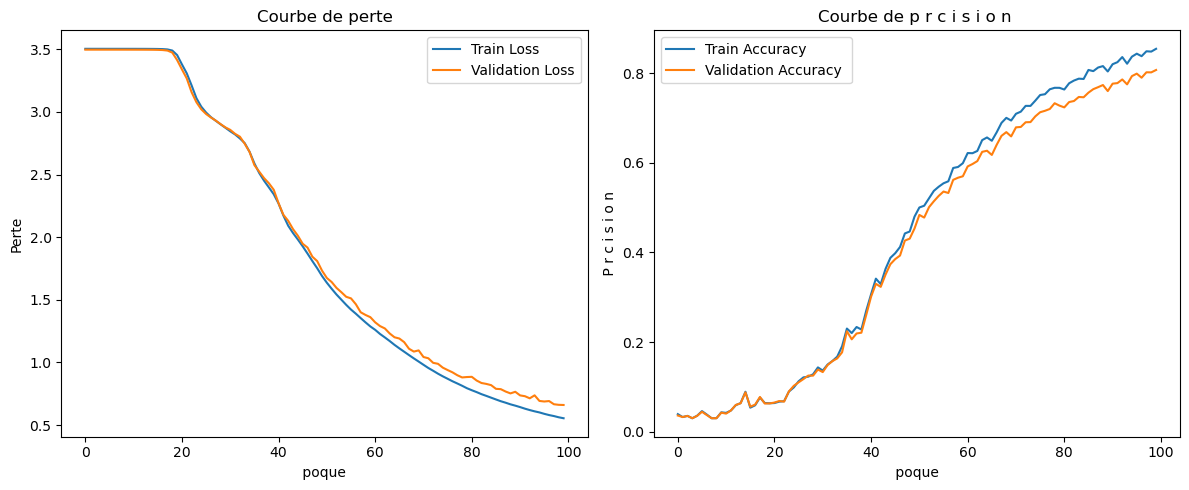

In [29]:
# D f i n i r le chemin vers le dossier d c o m p r e s s
data_dir = os.path.join(os.getcwd (), '/Users/hicham/Downloads/images-data-64/tifinagh-images')
print(data_dir)
current_working_directory = os.getcwd ()
print(current_working_directory)

# Charger le fichier CSV contenant les tiquettes
try:
    # labels_df = pd.read_csv(os.path.join(data_dir , '/kaggle/input/amhcdd/images-data-64/labels-map.csv'))
    labels_df = pd.read_csv(os.path.join(data_dir , '/Users/hicham/Downloads/images-data-64/labels-map.csv'), header=None, names=['image_path', 'label'])

    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns , "CSV must contain ’image_path’ and ’label’ columns"
except FileNotFoundError:
    print("labels -map.csv not found. Please check the dataset structure.")
# Alternative : construire un DataFrame partir des dossiers
image_paths = []
labels = []
for label_dir in os.listdir(data_dir):
    label_path = os.path.join(data_dir , label_dir)
    if os.path.isdir(label_path):
        for img_name in os.listdir(label_path):
            image_paths.append(os.path.join(label_path ,
            img_name))
            labels.append(label_dir)
labels_df = pd.DataFrame ({'image_path': image_paths , 'label': labels })

# V r i f i e r le DataFrame
assert not labels_df.empty , "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique ()} unique classes.")

# Encoder les tiquettes
label_encoder = LabelEncoder ()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Fonction pour charger et p r t r a i t e r une image
def load_and_preprocess_image(image_path , target_size =(32, 32)):
    """
    Load and preprocess an image: convert to grayscale , resize ,
    normalize
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path , cv2.IMREAD_GRAYSCALE)
    assert img is not None , f"Failed to load image: {image_path}"
    img = cv2.resize(img , target_size)
    img = img.astype(np.float32) / 255.0 # Normalisation
    return img.flatten () # Aplatir pour le r s e a u de neurones

# Charger toutes les images
X = np.array([ load_and_preprocess_image(os.path.join(data_dir ,path)) for path in labels_df['image_path']])
y = labels_df['label_encoded']. values

# V r i f i e r les dimensions
assert X.shape [0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape [1] == 32 * 32, f"Expected flattened image size of {32*32} , got {X.shape [1]}"

# Diviser en ensembles d’ entra nement , validation et test
X_temp , X_test , y_temp , y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state =42)
X_train , X_val , y_train , y_val = train_test_split(X_temp , y_temp , test_size =0.25, stratify=y_temp , random_state =42)


# Convertir explicitement en NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

assert X_train.shape [0] + X_val.shape [0] + X_test.shape [0] == X.shape[0], "Train -val -test split sizes must sum to total samples"

print(f"Train: {X_train.shape [0]} samples , Validation: {X_val.shape [0]} samples , Test: {X_test.shape [0]} samples")

# Encoder les tiquettes en one -hot pour la classification multiclasse
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = np.array(one_hot_encoder.fit_transform(y_train.reshape(-1, 1)))
y_val_one_hot = np.array(one_hot_encoder.transform(y_val.reshape(-1, 1)))
y_test_one_hot = np.array(one_hot_encoder.transform(y_test.reshape(-1, 1)))

# V r i f i e r que les tableaux one -hot sont des NumPy arrays
assert isinstance(y_train_one_hot , np.ndarray), "y_train_one_hot must be a numpy array"
assert isinstance(y_val_one_hot , np.ndarray), "y_val_one_hot must be a numpy array"
assert isinstance(y_test_one_hot , np.ndarray), "y_test_one_hot must be a numpy array"

# C r e r et e n t r a n e r le m o d l e
layer_sizes = [X_train.shape[1], 64, 32, num_classes] # 64 et 32 neurones c a c h s , 33 classes
nn = MultiClassNeuralNetwork(layer_sizes , model_optimization="SGD", learning_rate =0.01)
train_losses , val_losses , train_accuracies , val_accuracies = nn.train(X_train , y_train_one_hot , X_val , y_val_one_hot , epochs =100,batch_size =32 )

# TODO: Ajouter une validation c r o i s e pour valuer la robustesse du m o d l e
# TODO: I m p l m e n t e r l’optimiseur Adam pour une meilleure convergence

# P r d i c t i o n s et valuation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test , y_pred , target_names=label_encoder.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test , y_pred)
plt.figure(figsize =(10, 8))
sns.heatmap(cm, annot=True , fmt='d', cmap='Blues')
plt.title('Matrice de confusion (Test set)')
plt.xlabel(' P r d i t ')
plt.ylabel(' R e l ')
plt.savefig('confusion_matrix.png')
plt.show()

# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_accuracies , label='Train Accuracy ')
ax2.plot(val_accuracies , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()


Epoch 0, Train Loss: 2.1687, Val Loss: 1.5350, Train Acc: 0.5285, Val Acc:0.5118
Epoch 10, Train Loss: 0.8891, Val Loss: 0.8942, Train Acc: 0.7376, Val Acc:0.7130
Epoch 20, Train Loss: 0.8503, Val Loss: 0.8948, Train Acc: 0.7355, Val Acc:0.7179
Epoch 30, Train Loss: 0.8352, Val Loss: 0.9807, Train Acc: 0.7079, Val Acc:0.6935
Epoch 40, Train Loss: 0.8228, Val Loss: 0.9019, Train Acc: 0.7324, Val Acc:0.7114
Epoch 50, Train Loss: 0.8262, Val Loss: 0.8290, Train Acc: 0.7677, Val Acc:0.7433
Epoch 60, Train Loss: 0.8276, Val Loss: 0.8908, Train Acc: 0.7446, Val Acc:0.7092
Epoch 70, Train Loss: 0.8239, Val Loss: 0.8473, Train Acc: 0.7520, Val Acc:0.7229
Epoch 80, Train Loss: 0.8189, Val Loss: 0.8796, Train Acc: 0.7441, Val Acc:0.7055
Epoch 90, Train Loss: 0.8130, Val Loss: 0.8822, Train Acc: 0.7410, Val Acc:0.7126

Rapport de classification (Test set) :
              precision    recall  f1-score   support

          ya       0.94      0.78      0.86       171
         yab       0.63      0.4

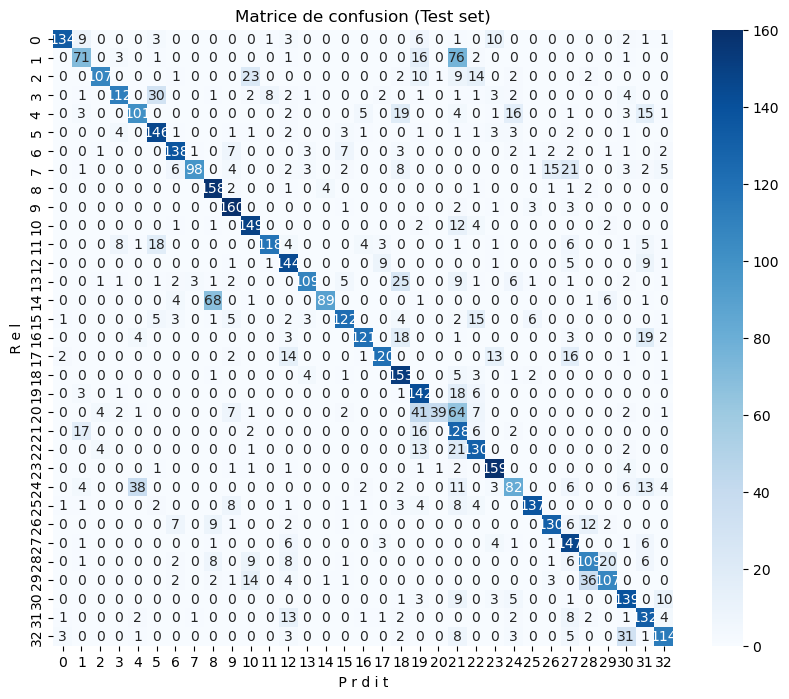

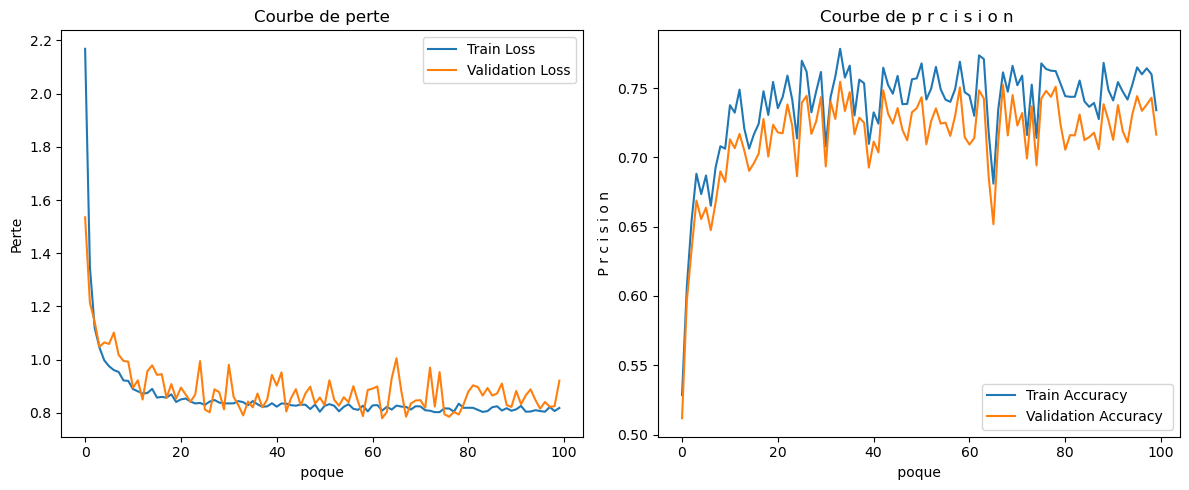

In [31]:
# V r i f i e r que les tableaux one -hot sont des NumPy arrays
assert isinstance(y_train_one_hot , np.ndarray), "y_train_one_hot must be a numpy array"
assert isinstance(y_val_one_hot , np.ndarray), "y_val_one_hot must be a numpy array"
assert isinstance(y_test_one_hot , np.ndarray), "y_test_one_hot must be a numpy array"

# C r e r et e n t r a n e r le m o d l e
layer_sizes = [X_train.shape[1], 64, 32, num_classes] # 64 et 32 neurones c a c h s , 33 classes
nn = MultiClassNeuralNetwork(layer_sizes , model_optimization="Adam", learning_rate =0.01)
train_losses , val_losses , train_accuracies , val_accuracies = nn.train(X_train , y_train_one_hot , X_val , y_val_one_hot , epochs =100,batch_size =32 )

# TODO: Ajouter une validation c r o i s e pour valuer la robustesse du m o d l e
# TODO: I m p l m e n t e r l’optimiseur Adam pour une meilleure convergence

# P r d i c t i o n s et valuation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test , y_pred , target_names=label_encoder.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test , y_pred)
plt.figure(figsize =(10, 8))
sns.heatmap(cm, annot=True , fmt='d', cmap='Blues')
plt.title('Matrice de confusion (Test set)')
plt.xlabel(' P r d i t ')
plt.ylabel(' R e l ')
plt.savefig('confusion_matrix.png')
plt.show()

# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_accuracies , label='Train Accuracy ')
ax2.plot(val_accuracies , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()

Testing learning_rate=0.001, batch_size=16 ...
Epoch 0, Train Loss: 3.0468, Val Loss: 2.8646, Train Acc: 0.1365, Val Acc:0.1393
Epoch 10, Train Loss: 0.8893, Val Loss: 0.8994, Train Acc: 0.7766, Val Acc:0.7436
Epoch 20, Train Loss: 0.6633, Val Loss: 0.6781, Train Acc: 0.8502, Val Acc:0.8181
Epoch 30, Train Loss: 0.5885, Val Loss: 0.6776, Train Acc: 0.8365, Val Acc:0.8051
Epoch 40, Train Loss: 0.5555, Val Loss: 0.6063, Train Acc: 0.8689, Val Acc:0.8419
Epoch 50, Train Loss: 0.5343, Val Loss: 0.5706, Train Acc: 0.8887, Val Acc:0.8565
Epoch 60, Train Loss: 0.5214, Val Loss: 0.5628, Train Acc: 0.8872, Val Acc:0.8550
Epoch 70, Train Loss: 0.5157, Val Loss: 0.5697, Train Acc: 0.8849, Val Acc:0.8474
Epoch 80, Train Loss: 0.5119, Val Loss: 0.6041, Train Acc: 0.8650, Val Acc:0.8263
Epoch 90, Train Loss: 0.5062, Val Loss: 0.5400, Train Acc: 0.9015, Val Acc:0.8689
Epoch 0, Train Loss: 2.9292, Val Loss: 2.5771, Train Acc: 0.2273, Val Acc:0.2211
Epoch 10, Train Loss: 0.8713, Val Loss: 0.9143, Train

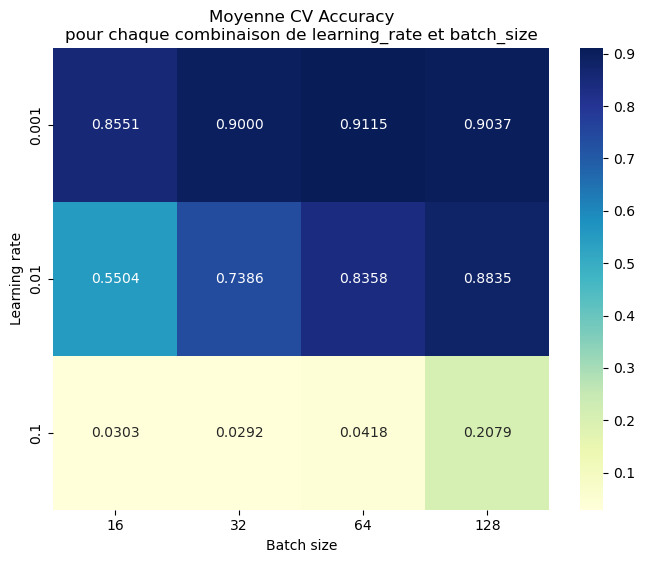

Epoch 0, Train Loss: 2.9388, Val Loss: 2.5222, Train Acc: 0.2126, Val Acc:0.2126
Epoch 10, Train Loss: 0.7856, Val Loss: 0.7242, Train Acc: 0.7885, Val Acc:0.7885
Epoch 20, Train Loss: 0.4182, Val Loss: 0.3972, Train Acc: 0.8929, Val Acc:0.8929
Epoch 30, Train Loss: 0.3022, Val Loss: 0.2767, Train Acc: 0.9301, Val Acc:0.9301
Epoch 40, Train Loss: 0.2503, Val Loss: 0.2392, Train Acc: 0.9394, Val Acc:0.9394
Epoch 50, Train Loss: 0.2176, Val Loss: 0.1977, Train Acc: 0.9551, Val Acc:0.9551
Epoch 60, Train Loss: 0.1962, Val Loss: 0.1768, Train Acc: 0.9622, Val Acc:0.9622
Epoch 70, Train Loss: 0.1834, Val Loss: 0.1720, Train Acc: 0.9633, Val Acc:0.9633
Epoch 80, Train Loss: 0.1756, Val Loss: 0.1634, Train Acc: 0.9682, Val Acc:0.9682
Epoch 90, Train Loss: 0.1649, Val Loss: 0.1552, Train Acc: 0.9715, Val Acc:0.9715

Rapport de classification (Test set) avec la meilleure combinaison :
              precision    recall  f1-score   support

          ya       0.98      0.96      0.97       171
  

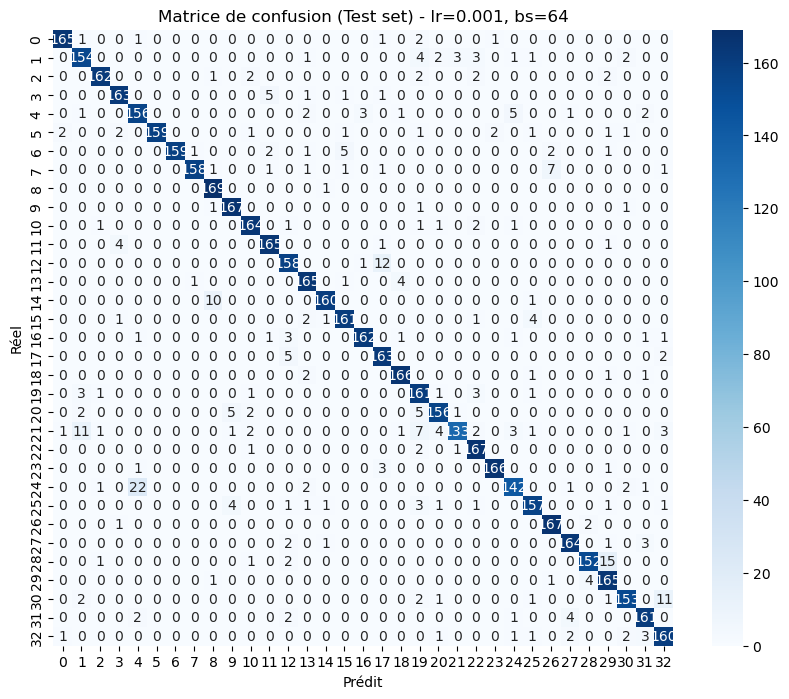

In [33]:
# ----- Définir les hyperparamètres à tester -----
learning_rates = [0.001, 0.01, 0.1]
batch_sizes    = [16, 32, 64,128]
n_splits       = 5

# Préparer un tableau pour stocker la performance moyenne (accuracy) pour chaque combinaison
mean_val_accuracy = np.zeros((len(learning_rates), len(batch_sizes)))

# Boucle de recherche par cross-validation sur chaque combinaison de hyperparamètres


for i, lr in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        print(f"Testing learning_rate={lr}, batch_size={bs} ...")
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_accuracies = []

        for train_index, val_index in kf.split(X_temp):
            X_train_fold = X_temp[train_index]
            X_val_fold   = X_temp[val_index]
            y_train_fold = y_temp_one_hot[train_index]
            y_val_fold   = y_temp_one_hot[val_index]

            # Initialiser un nouveau modèle avec le learning rate courant
            layer_sizes = [X_train_fold.shape[1], 64, 32, num_classes]
            nn = MultiClassNeuralNetwork(layer_sizes, model_optimization="Adam",learning_rate=lr)

            # Entraîner sur ce fold
            _, val_losses, _, val_accs = nn.train(
                X_train_fold, y_train_fold,
                X_val_fold,   y_val_fold,
                epochs=100, batch_size=bs
            )

            # Récupérer la dernière accuracy du fold de validation
            fold_accuracies.append(val_accs[-1])

        # Calculer la moyenne des accuracies sur les n_splits folds
        mean_val_accuracy[i, j] = np.mean(fold_accuracies)
        print(f"→ Moyenne CV accuracy pour lr={lr}, bs={bs} : {mean_val_accuracy[i, j]:.4f}")

# Déterminer la combinaison qui a la performance la plus élevée
best_idx = np.unravel_index(np.argmax(mean_val_accuracy), mean_val_accuracy.shape)
best_lr  = learning_rates[best_idx[0]]
best_bs  = batch_sizes[best_idx[1]]
best_acc = mean_val_accuracy[best_idx]
print(f"\nMeilleure combinaison : learning_rate={best_lr}, batch_size={best_bs} avec CV accuracy={best_acc:.4f}")

# ----- Visualisation des résultats sous forme de heatmap -----
plt.figure(figsize=(8, 6))
sns.heatmap(
    mean_val_accuracy,
    annot=True, fmt=".4f",
    xticklabels=batch_sizes,
    yticklabels=learning_rates,
    cmap="YlGnBu"
)
plt.title("Moyenne CV Accuracy\npour chaque combinaison de learning_rate et batch_size")
plt.xlabel("Batch size")
plt.ylabel("Learning rate")
plt.savefig("cv_accuracy_heatmap.png")
plt.show()

# ----- Réentraîner un modèle final sur tout X_temp avec la meilleure combinaison -----
layer_sizes_final = [X_temp.shape[1], 64, 32, num_classes]
nn_final = MultiClassNeuralNetwork(layer_sizes_final, model_optimization="Adam",learning_rate=best_lr)
# Reconstruire y_temp_one_hot si nécessaire :
# y_temp_one_hot = one_hot_encoder.fit_transform(y_temp.reshape(-1, 1))
nn_final.train(X_temp, y_temp_one_hot, X_temp, y_temp_one_hot, epochs=100, batch_size=best_bs)

# ----- Évaluer le modèle final sur le jeu de test -----
y_test_pred = nn_final.predict(X_test)
print("\nRapport de classification (Test set) avec la meilleure combinaison :")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Matrice de confusion (Test set)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice de confusion (Test set) - lr={best_lr}, bs={best_bs}")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig("confusion_matrix_best.png")
plt.show()

In [13]:

# Dossier d'entrée contenant les images
input_folder = '/Users/hicham/Downloads/images-data-64/tifinagh-images'

# Dossier de sortie
output_folder = '/Users/hicham/Downloads/images-data-64/images_augmentees'
os.makedirs(output_folder, exist_ok=True)

# Paramètres
rotation_angles = [15, -15]             # En degrés
translations = [(20, 10), (-10, -20)]   # (déplacement_x, déplacement_y)

# Parcourir chaque image du dossier
for filenamed in os.listdir(input_folder):
    inpsoudossier="/Users/hicham/Downloads/images-data-64/tifinagh-images/"+filenamed
    output_folder_dire=output_folder+"/"+filenamed
    os.mkdir(output_folder_dire)
    for filename in os.listdir(inpsoudossier):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(inpsoudossier, filename)
            image = cv2.imread(image_path)
    
            if image is None:
                print(f"Erreur lors du chargement de {filename}")
                continue
    
            h, w = image.shape[:2]
            base_name = os.path.splitext(filename)[0]
    
            # 1. Appliquer des rotations
            for angle in rotation_angles:
                center = (w // 2, h // 2)
                M_rot = cv2.getRotationMatrix2D(center, angle, 1.0)
                rotated = cv2.warpAffine(image, M_rot, (w, h))
                cv2.imwrite(os.path.join(output_folder_dire, f"{base_name}_rot{angle}.jpg"), rotated)
    
            # 2. Appliquer des translations
            for tx, ty in translations:
                M_trans = np.float32([[1, 0, tx], [0, 1, ty]])
                translated = cv2.warpAffine(image, M_trans, (w, h))
                cv2.imwrite(os.path.join(output_folder_dire, f"{base_name}trans{tx}{ty}.jpg"), translated)

print("Augmentation terminée.")

Augmentation terminée.


/Users/hicham/Downloads/images-data-64/images_augmentees
/Users/hicham
Loaded 112728 samples with 33 unique classes.
Train: 67636 samples , Validation: 22546 samples , Test: 22546 samples
Epoch 0, Train Loss: 2.7666, Val Loss: 2.3212, Train Acc: 0.2766, Val Acc:0.2732
Epoch 10, Train Loss: 0.8684, Val Loss: 0.8759, Train Acc: 0.7642, Val Acc:0.7348
Epoch 20, Train Loss: 0.6701, Val Loss: 0.7259, Train Acc: 0.8129, Val Acc:0.7765
Epoch 30, Train Loss: 0.5797, Val Loss: 0.6558, Train Acc: 0.8389, Val Acc:0.7955
Epoch 40, Train Loss: 0.5253, Val Loss: 0.6258, Train Acc: 0.8429, Val Acc:0.8048
Epoch 50, Train Loss: 0.4901, Val Loss: 0.5711, Train Acc: 0.8645, Val Acc:0.8243
Epoch 60, Train Loss: 0.4684, Val Loss: 0.5539, Train Acc: 0.8747, Val Acc:0.8316
Epoch 70, Train Loss: 0.4574, Val Loss: 0.5281, Train Acc: 0.8792, Val Acc:0.8387
Epoch 80, Train Loss: 0.4496, Val Loss: 0.5454, Train Acc: 0.8752, Val Acc:0.8343
Epoch 90, Train Loss: 0.4400, Val Loss: 0.5124, Train Acc: 0.8892, Val Acc:

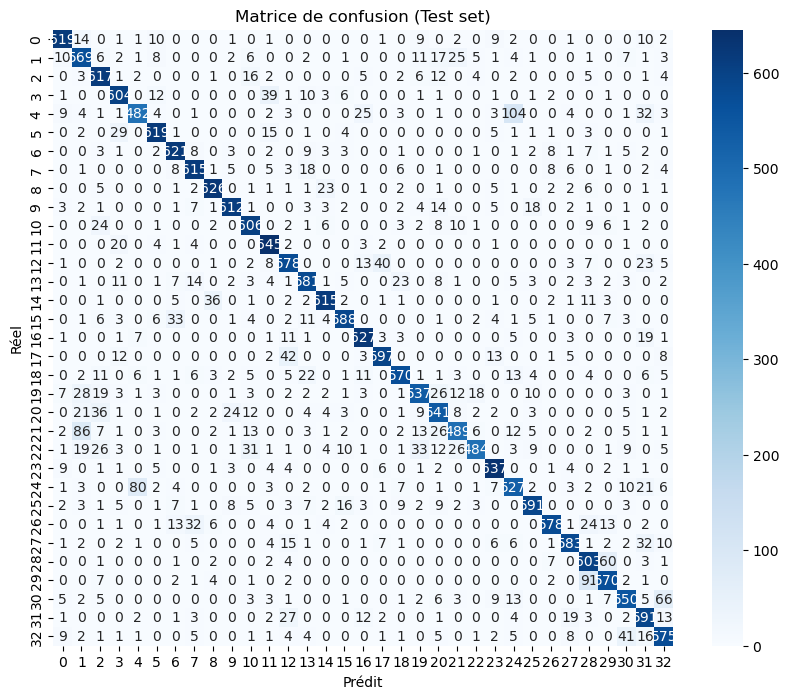

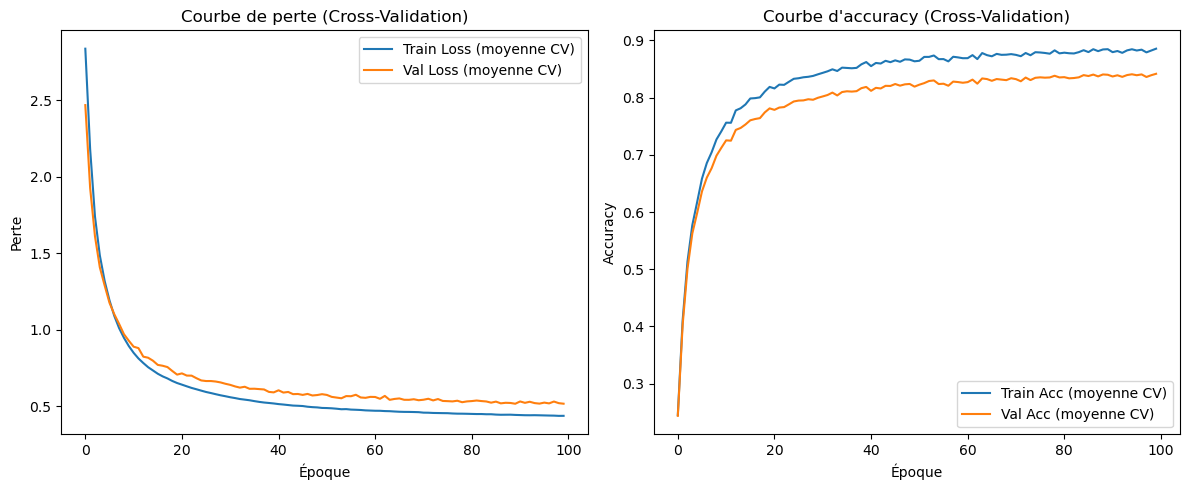

In [5]:
# D f i n i r le chemin vers le dossier d c o m p r e s s
data_dir = os.path.join(os.getcwd (), '/Users/hicham/Downloads/images-data-64/images_augmentees')
print(data_dir)
current_working_directory = os.getcwd ()
print(current_working_directory)

# Charger le fichier CSV contenant les tiquettes
try:
    # labels_df = pd.read_csv(os.path.join(data_dir , '/kaggle/input/amhcdd/images-data-64/labels-map.csv'))
    labels_df = pd.read_csv(os.path.join(data_dir , '/Users/hicham/Downloads/images-data-64/labels-map.csv'), header=None, names=['image_path', 'label'])

    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns , "CSV must contain ’image_path’ and ’label’ columns"
except FileNotFoundError:
    print("labels -map.csv not found. Please check the dataset structure.")
# Alternative : construire un DataFrame partir des dossiers
image_paths = []
labels = []
for label_dir in os.listdir(data_dir):
    label_path = os.path.join(data_dir , label_dir)
    if os.path.isdir(label_path):
        for img_name in os.listdir(label_path):
            image_paths.append(os.path.join(label_path ,
            img_name))
            labels.append(label_dir)
labels_df = pd.DataFrame ({'image_path': image_paths , 'label': labels })

# V r i f i e r le DataFrame
assert not labels_df.empty , "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique ()} unique classes.")

# Encoder les tiquettes
label_encoder = LabelEncoder ()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Fonction pour charger et p r t r a i t e r une image
def load_and_preprocess_image(image_path , target_size =(32, 32)):
    """
    Load and preprocess an image: convert to grayscale , resize ,
    normalize
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path , cv2.IMREAD_GRAYSCALE)
    assert img is not None , f"Failed to load image: {image_path}"
    img = cv2.resize(img , target_size)
    img = img.astype(np.float32) / 255.0 # Normalisation
    return img.flatten () # Aplatir pour le r s e a u de neurones

# Charger toutes les images
X = np.array([ load_and_preprocess_image(os.path.join(data_dir ,path)) for path in labels_df['image_path']])
y = labels_df['label_encoded']. values

# V r i f i e r les dimensions
assert X.shape [0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape [1] == 32 * 32, f"Expected flattened image size of {32*32} , got {X.shape [1]}"

# Diviser en ensembles d’ entra nement , validation et test
X_temp , X_test , y_temp , y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state =42)
X_train , X_val , y_train , y_val = train_test_split(X_temp , y_temp , test_size =0.25, stratify=y_temp , random_state =42)


# Convertir explicitement en NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

assert X_train.shape [0] + X_val.shape [0] + X_test.shape [0] == X.shape[0], "Train -val -test split sizes must sum to total samples"

print(f"Train: {X_train.shape [0]} samples , Validation: {X_val.shape [0]} samples , Test: {X_test.shape [0]} samples")




# ----- Charger toutes les images dans X et les labels dans y -----
X = np.array([
    load_and_preprocess_image(os.path.join(data_dir, path))
    for path in labels_df['image_path']
])
y = labels_df['label_encoded'].values

# Vérifier dimensions
assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape[1] == 32 * 32, f"Expected flattened image size of {32*32}, got {X.shape[1]}"

# ----- Diviser en jeu temporaire + test final (20 %) -----
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ----- Créer une version one-hot de y_temp pour la CV -----
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_temp_one_hot = one_hot_encoder.fit_transform(y_temp.reshape(-1, 1))
assert y_temp_one_hot.shape[0] == X_temp.shape[0] and y_temp_one_hot.shape[1] == num_classes

# ----- Définir le nombre de folds pour la cross-validation -----
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Listes pour stocker les métriques de chaque fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []


fold_idx = 1
for train_index, val_index in kf.split(X_temp):
    # Séparer en X_train_fold / X_val_fold et y_train_fold / y_val_fold
    X_train_fold = X_temp[train_index]
    X_val_fold   = X_temp[val_index]
    y_train_fold = y_temp_one_hot[train_index]
    y_val_fold   = y_temp_one_hot[val_index]

    # Initialiser un nouveau modèle pour chaque fold
    layer_sizes = [X_train_fold.shape[1], 64, 32, num_classes]
    nn = MultiClassNeuralNetwork(layer_sizes, model_optimization="Adam",learning_rate=0.001)

    # Entraîner sur ce fold (la méthode retourne déjà train_losses, val_losses, train_accuracies, val_accuracies)
    train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
        X_train_fold, y_train_fold,
        X_val_fold,   y_val_fold,
        epochs=100, batch_size=64
    )

    # Stocker les métriques de ce fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

    print(f"→ Fold {fold_idx} terminé : Val Accuracy finale = {val_accuracies[-1]:.4f}")
    fold_idx += 1

# ----- Calculer la moyenne et l’écart-type des accuracies finales sur tous les folds -----
final_val_accuracies = [accs[-1] for accs in fold_val_accuracies]
mean_val_acc = np.mean(final_val_accuracies)
std_val_acc  = np.std(final_val_accuracies)
print(f"\nMoyenne des accuracies sur {n_splits} folds : {mean_val_acc:.4f} ± {std_val_acc:.4f}")

# ----- Réentraîner un modèle final sur tout X_temp -----
# (Optionnel : pour obtenir le modèle à déployer ou pour évaluer sur le test final)
layer_sizes_final = [X_temp.shape[1], 64, 32, num_classes]
nn_final = MultiClassNeuralNetwork(layer_sizes_final,model_optimization="Adam", learning_rate=0.001)
# Créer y_temp_one_hot une seconde fois si nécessaire :
# y_temp_one_hot = one_hot_encoder.fit_transform(y_temp.reshape(-1, 1))
nn_final.train(X_temp, y_temp_one_hot, X_temp, y_temp_one_hot, epochs=100, batch_size=64)

# ----- Évaluer sur le jeu de test final -----
y_test_pred = nn_final.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Matrice de confusion (Test set)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion (Test set)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.savefig('confusion_matrix.png')
plt.show()

# (Optionnel) Tracer les courbes moyennes de perte et d’accuracy sur tous les folds
# Moyenne des courbes par époque
mean_train_losses = np.mean(np.array(fold_train_losses), axis=0)
mean_val_losses   = np.mean(np.array(fold_val_losses), axis=0)
mean_train_accs   = np.mean(np.array(fold_train_accuracies), axis=0)
mean_val_accs     = np.mean(np.array(fold_val_accuracies), axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Courbe de perte moyenne
ax1.plot(mean_train_losses, label='Train Loss (moyenne CV)')
ax1.plot(mean_val_losses,   label='Val Loss (moyenne CV)')
ax1.set_title('Courbe de perte (Cross-Validation)')
ax1.set_xlabel('Époque')
ax1.set_ylabel('Perte')
ax1.legend()

# Courbe d’accuracy moyenne
ax2.plot(mean_train_accs, label='Train Acc (moyenne CV)')
ax2.plot(mean_val_accs,   label='Val Acc (moyenne CV)')
ax2.set_title('Courbe d\'accuracy (Cross-Validation)')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.savefig('loss_accuracy_cv_plot.png')
plt.show()


Testing learning_rate=0.001, batch_size=32 ...
Epoch 0, Train Loss: 2.7799, Val Loss: 2.3506, Train Acc: 0.2724, Val Acc:0.2635
Epoch 10, Train Loss: 0.9256, Val Loss: 0.9539, Train Acc: 0.7291, Val Acc:0.7084
Epoch 20, Train Loss: 0.7749, Val Loss: 0.8325, Train Acc: 0.7745, Val Acc:0.7481
Epoch 30, Train Loss: 0.7341, Val Loss: 0.7433, Train Acc: 0.8084, Val Acc:0.7859
Epoch 40, Train Loss: 0.7143, Val Loss: 0.7521, Train Acc: 0.8011, Val Acc:0.7783
Epoch 50, Train Loss: 0.6984, Val Loss: 0.7446, Train Acc: 0.8077, Val Acc:0.7775
Epoch 60, Train Loss: 0.6908, Val Loss: 0.7209, Train Acc: 0.8141, Val Acc:0.7874
Epoch 70, Train Loss: 0.6850, Val Loss: 0.7135, Train Acc: 0.8155, Val Acc:0.7926
Epoch 80, Train Loss: 0.6796, Val Loss: 0.7176, Train Acc: 0.8204, Val Acc:0.7898
Epoch 90, Train Loss: 0.6743, Val Loss: 0.7171, Train Acc: 0.8096, Val Acc:0.7843
Epoch 0, Train Loss: 2.8354, Val Loss: 2.5204, Train Acc: 0.2288, Val Acc:0.2229
Epoch 10, Train Loss: 0.9277, Val Loss: 0.9761, Train

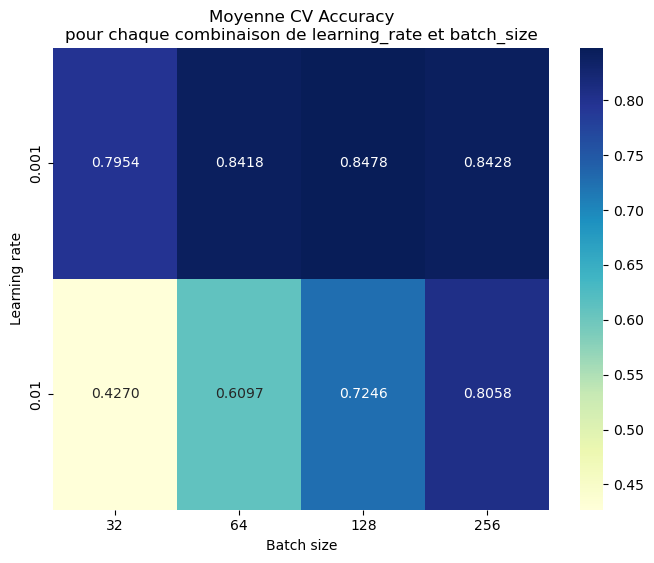

Epoch 0, Train Loss: 2.8514, Val Loss: 2.4550, Train Acc: 0.2518, Val Acc:0.2518
Epoch 10, Train Loss: 0.7977, Val Loss: 0.7421, Train Acc: 0.7729, Val Acc:0.7729
Epoch 20, Train Loss: 0.5638, Val Loss: 0.5269, Train Acc: 0.8395, Val Acc:0.8395
Epoch 30, Train Loss: 0.4621, Val Loss: 0.4346, Train Acc: 0.8672, Val Acc:0.8672
Epoch 40, Train Loss: 0.4111, Val Loss: 0.3820, Train Acc: 0.8852, Val Acc:0.8852
Epoch 50, Train Loss: 0.3807, Val Loss: 0.3598, Train Acc: 0.8913, Val Acc:0.8913
Epoch 60, Train Loss: 0.3591, Val Loss: 0.3393, Train Acc: 0.9003, Val Acc:0.9003
Epoch 70, Train Loss: 0.3444, Val Loss: 0.3191, Train Acc: 0.9061, Val Acc:0.9061
Epoch 80, Train Loss: 0.3314, Val Loss: 0.3129, Train Acc: 0.9082, Val Acc:0.9082
Epoch 90, Train Loss: 0.3194, Val Loss: 0.3081, Train Acc: 0.9120, Val Acc:0.9120

Rapport de classification (Test set) avec la meilleure combinaison :
              precision    recall  f1-score   support

          ya       0.90      0.95      0.92       683
  

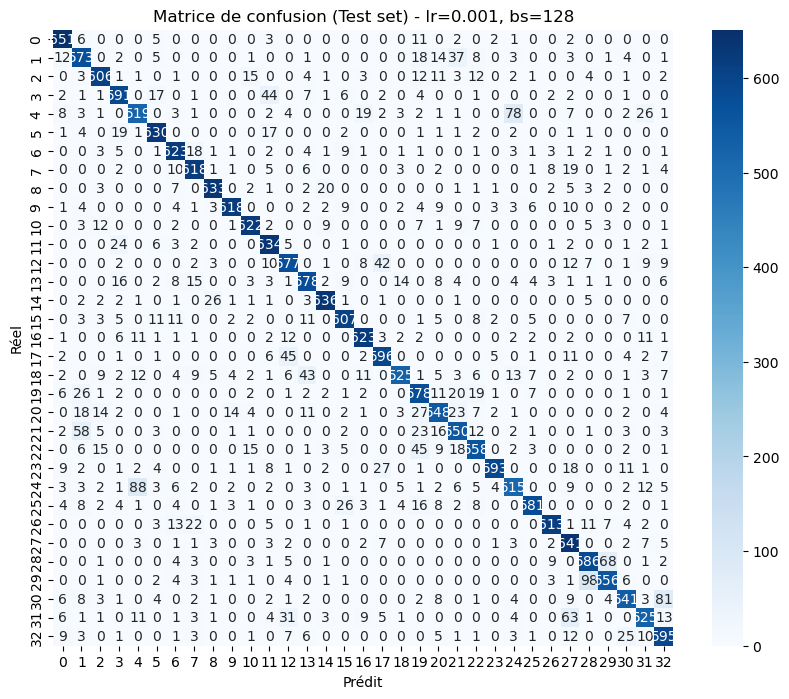

In [9]:
# ----- Définir les hyperparamètres à tester -----
learning_rates = [0.001, 0.01]
batch_sizes    = [32, 64, 128, 256]
n_splits       = 5

# Préparer un tableau pour stocker la performance moyenne (accuracy) pour chaque combinaison
mean_val_accuracy = np.zeros((len(learning_rates), len(batch_sizes)))

# Boucle de recherche par cross-validation sur chaque combinaison de hyperparamètres


for i, lr in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        print(f"Testing learning_rate={lr}, batch_size={bs} ...")
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_accuracies = []

        for train_index, val_index in kf.split(X_temp):
            X_train_fold = X_temp[train_index]
            X_val_fold   = X_temp[val_index]
            y_train_fold = y_temp_one_hot[train_index]
            y_val_fold   = y_temp_one_hot[val_index]

            # Initialiser un nouveau modèle avec le learning rate courant
            layer_sizes = [X_train_fold.shape[1], 64, 32, num_classes]
            nn = MultiClassNeuralNetwork(layer_sizes, model_optimization="Adam",learning_rate=lr)

            # Entraîner sur ce fold
            _, val_losses, _, val_accs = nn.train(
                X_train_fold, y_train_fold,
                X_val_fold,   y_val_fold,
                epochs=100, batch_size=bs
            )

            # Récupérer la dernière accuracy du fold de validation
            fold_accuracies.append(val_accs[-1])

        # Calculer la moyenne des accuracies sur les n_splits folds
        mean_val_accuracy[i, j] = np.mean(fold_accuracies)
        print(f"→ Moyenne CV accuracy pour lr={lr}, bs={bs} : {mean_val_accuracy[i, j]:.4f}")

# Déterminer la combinaison qui a la performance la plus élevée
best_idx = np.unravel_index(np.argmax(mean_val_accuracy), mean_val_accuracy.shape)
best_lr  = learning_rates[best_idx[0]]
best_bs  = batch_sizes[best_idx[1]]
best_acc = mean_val_accuracy[best_idx]
print(f"\nMeilleure combinaison : learning_rate={best_lr}, batch_size={best_bs} avec CV accuracy={best_acc:.4f}")

# ----- Visualisation des résultats sous forme de heatmap -----
plt.figure(figsize=(8, 6))
sns.heatmap(
    mean_val_accuracy,
    annot=True, fmt=".4f",
    xticklabels=batch_sizes,
    yticklabels=learning_rates,
    cmap="YlGnBu"
)
plt.title("Moyenne CV Accuracy\npour chaque combinaison de learning_rate et batch_size")
plt.xlabel("Batch size")
plt.ylabel("Learning rate")
plt.savefig("cv_accuracy_heatmap.png")
plt.show()

# ----- Réentraîner un modèle final sur tout X_temp avec la meilleure combinaison -----
layer_sizes_final = [X_temp.shape[1], 64, 32, num_classes]
nn_final = MultiClassNeuralNetwork(layer_sizes_final,  model_optimization="Adam",learning_rate=best_lr)
# Reconstruire y_temp_one_hot si nécessaire :
# y_temp_one_hot = one_hot_encoder.fit_transform(y_temp.reshape(-1, 1))
nn_final.train(X_temp, y_temp_one_hot, X_temp, y_temp_one_hot, epochs=100, batch_size=best_bs)

# ----- Évaluer le modèle final sur le jeu de test -----
y_test_pred = nn_final.predict(X_test)
print("\nRapport de classification (Test set) avec la meilleure combinaison :")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Matrice de confusion (Test set)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice de confusion (Test set) - lr={best_lr}, bs={best_bs}")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig("confusion_matrix_best.png")
plt.show()